In [1]:
# default_exp batteries

# Batteries

A collection of utility functions for converting Kate's Excel Sheet into a set of reproducible batteries that can be easily combined into domains. These contain a set of calculators that convert the data and define raw, calculated, and normalized fields.

In [2]:
# export

import os
import yaml

import pandas as pd
import numpy as np

from autoneuro.calculators import *
from autoneuro.operators import *
from autoneuro.field_mapping import FieldMapper

We'll need some data to properly test all of these.

In [3]:
all_neuro = pd.read_excel('data/neuro_data.xlsx',
                          na_values=['na', '-', 'nd']).groupby(['PatientID', 'Visit']).first().drop(['VisitDate'], axis=1)
all_neuro.replace({'Race': {2: 'AA',
                            1: 'white',
                            3: 'asian'},
                   'Sex': {1: 'male', 2: 'female'}},
                  inplace=True)

Then we'll need to normalize the field names.

In [4]:
mapper = FieldMapper.from_file('data/field_mappings.xlsx')
map_neuro = mapper.convert(all_neuro, 'oldneuro_id', 'internal_field')
map_neuro.head()

abdominal_girth  age  age_first_drivers_license  \
PatientID Visit                                                    
1         1                  NaN   59                        NaN   
          2                  NaN   62                        NaN   
2         1                  NaN   62                        NaN   
          2                  NaN   67                        NaN   
4         1                  NaN   65                        NaN   

                 age_first_used_drug  aids_defining_indicat2_2dd  \
PatientID Visit                                                    
1         1                      NaN                         NaN   
          2                      NaN                         NaN   
2         1                      NaN                         NaN   
          2                      NaN                         NaN   
4         1                      NaN                         NaN   

                 aids_defining_indicators  also_driving_assessment  \
PatientID Visit                                                      
1         1                           NaN                      NaN   
          2                           NaN                      NaN   
2         1                           NaN                      NaN   
          2                           NaN                      NaN   
4         1                           NaN                      NaN   

                 amitriptyline_end_date  amitriptyline_start_date  \
PatientID Visit                                                     
1         1                         NaN                       NaN   
          2                         NaN                       NaN   
2         1                         NaN                       NaN   
          2                         NaN                       NaN   
4         1                         NaN                       NaN   

                 amoxapine_end_date  ...  year_diagnosed_tuberculosi  \
PatientID Visit                      ...                               
1         1                     NaN  ...                         NaN   
          2                     NaN  ...                         NaN   
2         1                     NaN  ...                         NaN   
          2                     NaN  ...                         NaN   
4         1                     NaN  ...                         NaN   

                 year_diagnosed_uterine_can  year_diagnosed_with_asthma  \
PatientID Visit                                                           
1         1                             NaN                         NaN   
          2                             NaN                         NaN   
2         1                             NaN                         NaN   
          2                             NaN                         NaN   
4         1                             NaN                         NaN   

                 year_diagnosed_with_copd  year_diagnosed_with_diabet  \
PatientID Visit                                                         
1         1                           NaN                         NaN   
          2                           NaN                         NaN   
2         1                           NaN                         NaN   
          2                           NaN                         NaN   
4         1                           NaN                         NaN   

                 year_diagnosed_with_elevat  year_diagnosed_with_hypert  \
PatientID Visit                                                           
1         1                             NaN                         NaN   
          2                             NaN                         NaN   
2         1                             NaN                         NaN   
          2                             NaN                         NaN   
4         1                             NaN                         NaN   

                 ye

In [5]:
# export
# hide

def create_scaling(scaling_df, raw_field, scaled_field):
    """Returns a dict that can be used to create a BinedscalingOp"""
    edges = scaling_df.groupby(scaled_field)[raw_field].min()
    
    data = {'type': 'binned_scaling',
            'measure_col': raw_field,
            'bins': []}
    data['bins'] = [{'scaled': s, 'min': m} for s, m in edges.to_dict().items()]
    
    return data


def check_battery(battery_cls, neuro_data, check_mean = False):
    
    battery = battery_cls.from_defaults()
    
    clean_data = neuro_data[battery.required_fields].dropna()
    assert len(clean_data.index) > 0, 'No data matching these fields was found.'
    
    results = battery.scaled_data(clean_data)
    
    missing_frac = results.isnull().mean()
    missing_too_much = missing_frac > 0.3
    if missing_too_much.any():
        items = missing_frac[missing_too_much].to_dict().items()
        msg = [f'{field}: {val}' for field, val in items]
        assert False, 'Too many Nans: ' + ', '.join(msg)
    
    if battery.z_scaled & check_mean:
        means = results.mean()
        for field, mean in means.to_dict().items():
            assert (mean < 1.6) & (mean > -1.6), f'{field} fell outside expected range: {mean}'
            
    print(battery.explain(clean_data.iloc[0]))
    
    results.plot(kind = 'hist')    
    

# Battery

In the abstract, a battery is a collection of `TestCalculator` objects and definitions about which fields are measurements, infered, and normalized.

In [47]:
# export

class AbstractBattery(object):
    
    def __init__(self, calculator, scaled_fields, z_scaled = True):
        
        self.calculator = calculator
        self.scaled_fields = scaled_fields
        self.z_scaled = z_scaled
        
    @property
    def required_fields(self):
        return self.calculator.fields
        
    def explain(self, data):
        return self.calculator.explain(data)
    
    def scaled_data(self, df):
        
        data = self.calculator.process_dataframe(df)
        return data[self.scaled_fields]
        
    @classmethod
    def check_battery(battery_cls, data):
        check_battery(battery_cls, data, check_mean = False)
        

## Brief Visiospatial Memory Test

In [48]:
# export 
# hide

class BVMTBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        bvmt_test_definition = os.path.join(root_data, 'test_calculators/BVMT.yaml')
        bvmt_calc = TestCalculator.from_config(yaml.full_load(open(bvmt_test_definition)))
        
        heaton_norm_definition = os.path.join(root_data, 'norms/from_kate/heaton_bvmt.yaml')
        heaton_bvmt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_norm_definition)))
        
        return BVMTBattery(bvmt_calc + heaton_bvmt_calc, 
                           ['bvmt_immediate_heaton','bvmt_retention_heaton'])
        


Input: 
 age:59.0
 bvmt_delay:0.0
 bvmt_false_pos:3.0
 bvmt_hits:6.0
 bvmt_trial1:2.0
 bvmt_trial2:5.0
 bvmt_trial3:5.0
Calculating: ['bvmt_immediate']
Used Equation: bvmt_trial1+bvmt_trial2+bvmt_trial3 = 12.0 = bvmt_immediate 

Calculating: ['bvmt_retention_denom']
Aggregation: max [bvmt_trial2, bvmt_trial3]  = 5.0 

Calculating: ['bvmt_retention']
Used Equation: bvmt_delay/bvmt_retention_denom = 0.0 = bvmt_retention 

Calculating: ['bvmt_retention']
Clipped bvmt_retention to [0, 1] 

Calculating: ['bvmt_recognition']
Used Equation: bvmt_hits-bvmt_false_pos = 3.0 = bvmt_recognition 

Calculating: ['bvmt_immediate_heaton']
Matched: (59 <= age) & (age <= 62)
Expected 22.66+/-5.39 but observed 12.0
Scaled to: z=-1.9777365491651206 

Calculating: ['bvmt_retention_heaton']
Matched: (59 <= age) & (age <= 62)
Expected 0.937+/-0.087 but observed 0.0
Scaled to: z=-10.770114942528737 

Calculating: ['bvmt_delay_heaton']
Matched: (59 <= age) & (age <= 62)
Expected 8.59+/-2.13 but observed 0.0
Sc

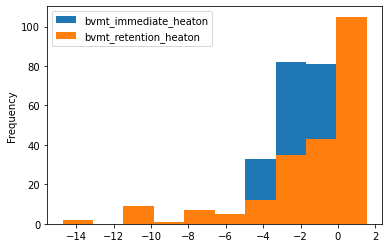

In [49]:
BVMTBattery.check_battery(map_neuro)

## HVLT

In [51]:
# export 
# hide

class HVLTBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        heaton_hvlt_norm_definition = os.path.join(root_data, 'norms/from_kate/heaton_hvlt.yaml')
        heaton_hvlt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_hvlt_norm_definition)))
        
        return HVLTBattery(heaton_hvlt_calc, 
                           ['hvlt_recognition_heaton', 'hvlt_delay_heaton', 'hvlt_total_heaton'])

Input: 
 age:61.0
 hvlt_delay:6.0
 hvlt_false_pos:5.0
 hvlt_hits:12.0
 hvlt_trial1:6.0
 hvlt_trial2:8.0
 hvlt_trial3:10.0
Calculating: ['hvlt_total']
Used Equation: hvlt_trial1+hvlt_trial2+hvlt_trial3 = 24.0 = hvlt_total 

Calculating: ['hvlt_recognition']
Used Equation: hvlt_hits+hvlt_false_pos = 17.0 = hvlt_recognition 

Calculating: ['hvlt_total_heaton']
Matched: age >= 54
Expected 27.86+/-3.95 but observed 24.0
Scaled to: z=-0.9772151898734175 

Calculating: ['hvlt_delay_heaton']
Matched: age >= 54
Expected 10.06+/-1.73 but observed 6.0
Scaled to: z=-2.3468208092485554 

Calculating: ['hvlt_recognition_heaton']
Matched: age >= 54
Expected 10.79+/-1.61 but observed 17.0
Scaled to: z=3.8571428571428577 

Resulting in: 
 hvlt_delay_heaton:-2.3468208092485554
 hvlt_recognition:17.0
 hvlt_recognition_heaton:3.8571428571428577
 hvlt_total:24.0
 hvlt_total_heaton:-0.9772151898734175
None


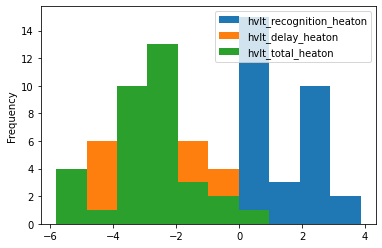

In [52]:
HVLTBattery.check_battery(map_neuro)

## SENAS Wordlist

In [53]:
# export 
# hide

class SENASWordlistBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        senas_wordlist_definition = os.path.join(root_data, 'norms/senas/worldlist_learning.yaml')
        senas_wordlist_calc = TestCalculator.from_config(yaml.full_load(open(senas_wordlist_definition)))
        
        return SENASWordlistBattery(senas_wordlist_calc, 
                                    ['senas_wordlist_total'],
                                    z_scaled=False)

Input: 
 senas_wordlist_t1:4.0
 senas_wordlist_t2:10.0
 senas_wordlist_t3:10.0
 senas_wordlist_t4:12.0
 senas_wordlist_t5:11.0
Calculating: ['senas_wordlist_total']
Used Equation: senas_wordlist_t1 + senas_wordlist_t2 + senas_wordlist_t3 + senas_wordlist_t4 + senas_wordlist_t5 = 47.0 = senas_wordlist_total 

Calculating: ['senas_wordlist_total_plc']
Used Equation: senas_wordlist_total = 47.0 = senas_wordlist_total_plc 

Resulting in: 
 senas_wordlist_total:47.0
 senas_wordlist_total_plc:47.0
None


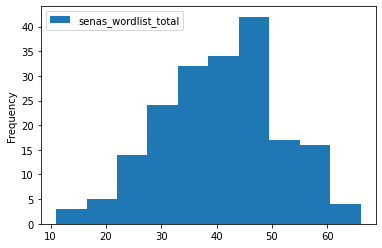

In [54]:
SENASWordlistBattery.check_battery(map_neuro)

## Letter Fluency

In [56]:
# export
# hide

class LetterFluencyBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        phenomic_placeholder = os.path.join(root_data, 'norms/placeholders/letter_fluency.yaml')
        phenomic_calc = TestCalculator.from_config(yaml.full_load(open(phenomic_placeholder)))

        return LetterFluencyBattery(phenomic_calc, 
                                    ['letterfluencyfas_total_heaton'],
                                    z_scaled=True)

Input: 
 age:59.0
 education:10.0
 letterfluencya_q1:0.0
 letterfluencya_q2:2.0
 letterfluencya_q3:2.0
 letterfluencya_q4:1.0
 letterfluencyf_q1:4.0
 letterfluencyf_q2:1.0
 letterfluencyf_q3:0.0
 letterfluencyf_q4:0.0
 letterfluencys_q1:1.0
 letterfluencys_q2:1.0
 letterfluencys_q3:3.0
 letterfluencys_q4:1.0
Calculating: ['letterfluencyf_total']
Used Equation: letterfluencyf_q1+letterfluencyf_q2+letterfluencyf_q3+letterfluencyf_q4 = 5.0 = letterfluencyf_total 

Calculating: ['letterfluencya_total']
Used Equation: letterfluencya_q1+letterfluencya_q2+letterfluencya_q3+letterfluencya_q4 = 5.0 = letterfluencya_total 

Calculating: ['letterfluencys_total']
Used Equation: letterfluencys_q1+letterfluencys_q2+letterfluencys_q3+letterfluencys_q4 = 6.0 = letterfluencys_total 

Calculating: ['letterfluencyfas_total']
Used Equation: letterfluencyf_total+letterfluencya_total+letterfluencys_total = 16.0 = letterfluencyfas_total 

Calculating: ['letterfluencyfas_total_heaton']
Matched: (16 <= age) & 

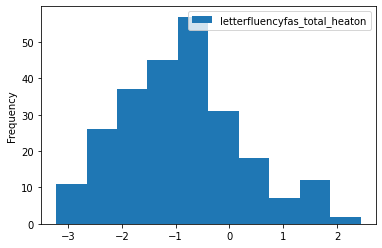

In [57]:
LetterFluencyBattery.check_battery(map_neuro)

## Category Fluency - Animals

In [58]:
# export 
# hide

class CategoryFluencyAnimalsBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        heaton_gender = CategoricalOp('gender', {'male': 1, 'female': 2}, 'heaton_gender')
        heaton_race = CategoricalOp('race', {'AA': 1, 'white': 2, 'asian': 2, 4: 2}, 'heaton_race')
        
        total_op = EquationOp("categoryfluency_total",
                              "categoryfluency_q1+categoryfluency_q2+categoryfluency_q3+categoryfluency_q4",
                              ['categoryfluency_q1', 'categoryfluency_q2', 'categoryfluency_q3', 'categoryfluency_q4'])
        
        heaton_scaling = pd.read_csv('data/norms/from_kate/sheets/Heaton.csv')
        cat_scaling = create_scaling(heaton_scaling, 'categoryfluency_total', 'categoryfluency_total_scaled')
        
        cat_heaton_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/Animals.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'categoryfluency_total_scaled',
                                                          'categoryfluency_total_heaton',
                                                          extra_filter = 'heaton_race == 2')
        


        cat_heaton_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/Animals_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'categoryfluency_total_scaled',
                                                          'categoryfluency_total_heaton',
                                                          extra_filter = 'heaton_race == 1')
        
        
        cat_heaton_1.incoperate(cat_heaton_2)
    
        
        scaler = TestCalculator('Animals_scaling',
                               [heaton_gender, heaton_race,
                                total_op,
                                AbstractOperation.from_config(cat_scaling),
                                cat_heaton_1
                               ])
        
        return CategoryFluencyAnimalsBattery(scaler, 
                                      ['categoryfluency_total_heaton'])

Input: 
 age:59
 categoryfluency_q1:5.0
 categoryfluency_q2:5.0
 categoryfluency_q3:4.0
 categoryfluency_q4:0.0
 education:10
 gender:male
 race:AA
Calculating: ['heaton_gender']
gender:male -> heaton_gender:1 

Calculating: ['heaton_race']
race:AA -> heaton_race:1 

Calculating: ['categoryfluency_total']
Used Equation: categoryfluency_q1+categoryfluency_q2+categoryfluency_q3+categoryfluency_q4 = 14.0 = categoryfluency_total 

Calculating: ['categoryfluency_total_scaled']
categoryfluency_total matched 14.0, scaled to 7.0 

Calculating: ['categoryfluency_total_heaton']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 34
Scaled to: z=-1.6 

Resulting in: 
 categoryfluency_total:14.0
 categoryfluency_total_heaton:-1.6
 categoryfluency_total_scaled:7.0
 heaton_gender:1
 heaton_race:1
None


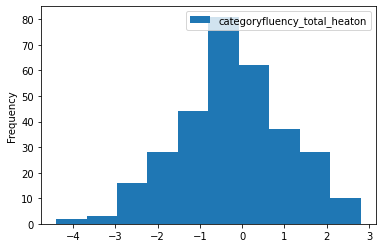

In [59]:
CategoryFluencyAnimalsBattery.check_battery(map_neuro)

## BNT-30

In [32]:
# export 
# hide

class BNT30Battery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        total_op = EquationOp("bnt30_plc",
                              "bnt30",
                              ['bnt30'])

        
        calc = TestCalculator('bnt30_placeholder',
                              [total_op])
        
        return BNT30Battery(calc, 
                            ['bnt30_plc'],
                            z_scaled=False)

In [34]:
#BNT30Battery.check_battery(map_neuro)

## Clock Drawing

Completely placeholder

In [60]:
# export 
# hide

class ClockDrawingBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        total_op = EquationOp("clockcommand1_plc",
                              "clockcommand1",
                              ['clockcommand1', 'clockcopy1'])

        
        calc = TestCalculator('clockdrawing_placeholder',
                              [total_op])
        
        return ClockDrawingBattery(calc, 
                                   ['clockcommand1_plc'],
                                   z_scaled=False)

Input: 
 clockcommand1:10.0
 clockcopy1:10.0
Calculating: ['clockcommand1_plc']
Used Equation: clockcommand1 = 10.0 = clockcommand1_plc 

Resulting in: 
 clockcommand1_plc:10.0
None


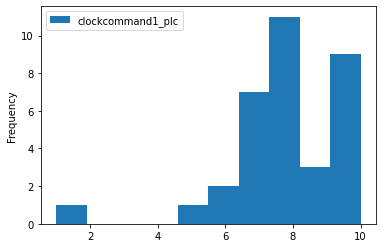

In [61]:
ClockDrawingBattery.check_battery(map_neuro)

## ROCF

Completely placeholder

In [63]:
# export 
# hide

class ROCFBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        total_op = EquationOp("rocf_plc",
                              "rocf",
                              ['rocf', 'rocftime'])

        
        calc = TestCalculator('rocf_placeholder',
                              [total_op])
        
        return ROCFBattery(calc, 
                           ['rocf_plc'],
                           z_scaled=False)

Input: 
 rocf:29.0
 rocftime:417.0
Calculating: ['rocf_plc']
Used Equation: rocf = 29.0 = rocf_plc 

Resulting in: 
 rocf_plc:29.0
None


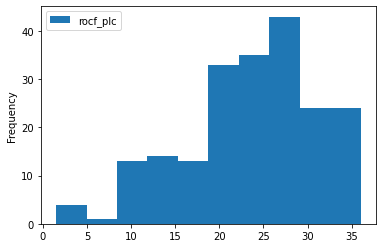

In [64]:
ROCFBattery.check_battery(map_neuro)

## Grooved Peg Board

In [66]:
# export 
# hide

class GroovedPegBoardBattery(AbstractBattery):
    
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        heaton_gender = CategoricalOp('gender', {'male': 1, 'female': 2}, 'heaton_gender')
        heaton_race = CategoricalOp('race', {'AA': 1, 'white': 2, 'asian': 2, 4: 2}, 'heaton_race')
        
        heaton_scaling = pd.read_csv('data/norms/from_kate/sheets/Heaton.csv')
        gpd = create_scaling(heaton_scaling, 'groovedpegdom', 'groovedpegdom_scaled')
        gpn = create_scaling(heaton_scaling, 'groovedpegnondom', 'groovedpegnondom_scaled')
        
        grooved_peg_dom_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/GPD.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'groovedpegdom_scaled',
                                                          'groovedpegdom_heaton',
                                                          extra_filter = 'heaton_race == 2')
        
        grooved_peg_ndom_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/GPN.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender', 'heaton_race', 'education'],
                                                          'groovedpegnondom_scaled',
                                                          'groovedpegnondom_heaton',
                                                          extra_filter = 'heaton_race == 2')

        grooved_peg_dom_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/GPD_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'groovedpegdom_scaled',
                                                          'groovedpegdom_heaton',
                                                          extra_filter = 'heaton_race == 1')
        
        grooved_peg_ndom_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/GPN_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender', 'heaton_race', 'education'],
                                                          'groovedpegnondom_scaled',
                                                          'groovedpegnondom_heaton',
                                                          extra_filter = 'heaton_race == 1')
        
        grooved_peg_dom_1.incoperate(grooved_peg_dom_2)
        grooved_peg_ndom_1.incoperate(grooved_peg_ndom_2)
    
        
        
        scaler = TestCalculator('grooved_pegboard_scaling',
                               [heaton_gender, heaton_race,
                                AbstractOperation.from_config(gpd),
                                AbstractOperation.from_config(gpn),
                                grooved_peg_dom_1, grooved_peg_ndom_1,
                               ])
        
        return GroovedPegBoardBattery(scaler, 
                           ['groovedpegdom_heaton', 'groovedpegnondom_heaton'])

Input: 
 age:59
 education:10
 gender:male
 groovedpegdom:98.0
 groovedpegnondom:140.0
 race:AA
Calculating: ['heaton_gender']
gender:male -> heaton_gender:1 

Calculating: ['heaton_race']
race:AA -> heaton_race:1 

Calculating: ['groovedpegdom_scaled']
groovedpegdom matched 89.0, scaled to 5.0 

Calculating: ['groovedpegnondom_scaled']
groovedpegnondom matched 131.0, scaled to 3.0 

Calculating: ['groovedpegdom_heaton']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 34
Scaled to: z=-1.6 

Calculating: ['groovedpegnondom_heaton']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 25
Scaled to: z=-2.5 

Resulting in: 
 groovedpegdom_heaton:-1.6
 groovedpegdom_scaled:5.0
 groovedpegnondom_heaton:-2.5
 groovedpegnondom_scaled:3.0
 heaton_gender:1
 heaton_race:1
None


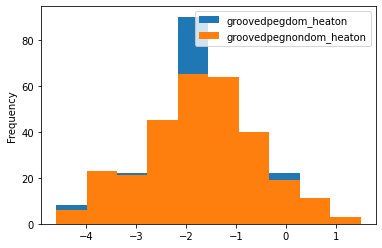

In [67]:
GroovedPegBoardBattery.check_battery(map_neuro)

## Trail A

In [68]:
# export
# hide

class TrailABattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        heaton_gender = CategoricalOp('gender', {'male': 1, 'female': 2}, 'heaton_gender')
        heaton_race = CategoricalOp('race', {'AA': 1, 'white': 2, 'asian': 2, 4: 2}, 'heaton_race')
        
        heaton_scaling = pd.read_csv('data/norms/from_kate/sheets/Heaton.csv')
        traila_scaling = create_scaling(heaton_scaling, 'traila', 'traila_scaled')
        
        traila_heaton_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/TrailsA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'traila_scaled',
                                                          'traila_heaton',
                                                          extra_filter = 'heaton_race == 2')
        


        traila_heaton_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/TrailsA_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'traila_scaled',
                                                          'traila_heaton',
                                                          extra_filter = 'heaton_race == 1')
        
        
        traila_heaton_1.incoperate(traila_heaton_2)
    
        
        scaler = TestCalculator('trailA_scaling',
                               [heaton_gender, heaton_race,
                                AbstractOperation.from_config(traila_scaling),
                                traila_heaton_1
                               ])
        
        return TrailABattery(scaler, 
                             ['traila_heaton'])

Input: 
 age:59
 education:10
 gender:male
 race:AA
 traila:50.0
Calculating: ['heaton_gender']
gender:male -> heaton_gender:1 

Calculating: ['heaton_race']
race:AA -> heaton_race:1 

Calculating: ['traila_scaled']
traila matched 45.0, scaled to 6.0 

Calculating: ['traila_heaton']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 36.0
Scaled to: z=-1.4 

Resulting in: 
 heaton_gender:1
 heaton_race:1
 traila_heaton:-1.4
 traila_scaled:6.0
None


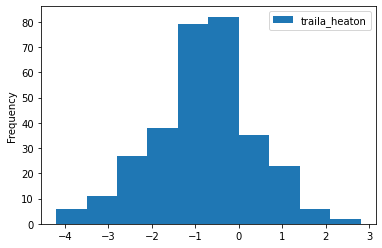

In [69]:
TrailABattery.check_battery(map_neuro)

## TrailB

In [70]:
# export 
# hide

class TrailBBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        heaton_gender = CategoricalOp('gender', {'male': 1, 'female': 2}, 'heaton_gender')
        heaton_race = CategoricalOp('race', {'AA': 1, 'white': 2, 'asian': 2, 4: 2}, 'heaton_race')
        
        heaton_scaling = pd.read_csv('data/norms/from_kate/sheets/Heaton.csv')
        trailb_scaling = create_scaling(heaton_scaling, 'trailb', 'trailb_scaled')
        
        trailb_heaton_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/TrailsB.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'trailb_scaled',
                                                          'trailb_heaton',
                                                          extra_filter = 'heaton_race == 2')
        
        trailb_heaton_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/TrailsB_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'trailb_scaled',
                                                          'trailb_heaton',
                                                          extra_filter = 'heaton_race == 1')
        trailb_heaton_1.incoperate(trailb_heaton_2)
        scaler = TestCalculator('trailB_scaling',
                               [heaton_gender, heaton_race,
                                AbstractOperation.from_config(trailb_scaling),
                                trailb_heaton_1
                               ])
        
        if final_cols is None:
            final_cols = ['trailb_heaton']
        
        return TrailBBattery(scaler, 
                             final_cols)

Input: 
 age:59
 education:10
 gender:male
 race:AA
 trailb:130.0
Calculating: ['heaton_gender']
gender:male -> heaton_gender:1 

Calculating: ['heaton_race']
race:AA -> heaton_race:1 

Calculating: ['trailb_scaled']
trailb matched 124, scaled to 6 

Calculating: ['trailb_heaton']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 37.0
Scaled to: z=-1.3 

Resulting in: 
 heaton_gender:1
 heaton_race:1
 trailb_heaton:-1.3
 trailb_scaled:6
None


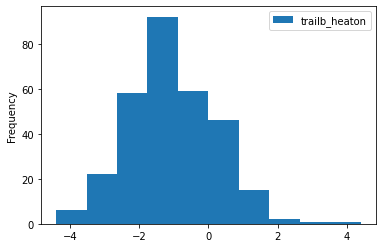

In [71]:
TrailBBattery.check_battery(map_neuro)

## WAIS-4 Digit-Symbol Coding

Currently only a placeholder.

In [72]:
# export 
# hide

class WAIS4DigitSymbolBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        wais4_test_definition = os.path.join(root_data, 'norms/placeholders/wais4.yaml')
        wais4_calc = TestCalculator.from_config(yaml.full_load(open(wais4_test_definition)))
        
        if final_cols is None:
            final_cols =  ['digitsforwardwais4_plc']
        
        return WAIS4DigitSymbolBattery(wais4_calc, 
                               final_cols,
                                z_scaled=False)

Input: 
 age:62.0
 digitsbackwardwais4:3.0
 digitsforwardwais4:5.0
 digitssequencingwais4:4.0
 ldsbwais4:5.0
 ldsfwais4:7.0
 ldsswais4:4.0
Calculating: ['digitsforwardwais4_plc']
Used Equation: digitsforwardwais4 = 5.0 = digitsforwardwais4_plc 

Calculating: ['ldsfwais4_plc']
Used Equation: ldsfwais4 = 7.0 = ldsfwais4_plc 

Calculating: ['digitsbackwardwais4_plc']
Used Equation: digitsbackwardwais4 = 3.0 = digitsbackwardwais4_plc 

Calculating: ['backwards_lds_plc']
Used Equation: ldsbwais4 = 5.0 = backwards_lds_plc 

Calculating: ['digitssequencingwais4_plc']
Used Equation: digitssequencingwais4 = 4.0 = digitssequencingwais4_plc 

Calculating: ['ldsswais4_plc']
Used Equation: ldsswais4 = 4.0 = ldsswais4_plc 

Resulting in: 
 backwards_lds_plc:5.0
 digitsbackwardwais4_plc:3.0
 digitsforwardwais4_plc:5.0
 digitssequencingwais4_plc:4.0
 ldsfwais4_plc:7.0
 ldsswais4_plc:4.0
None


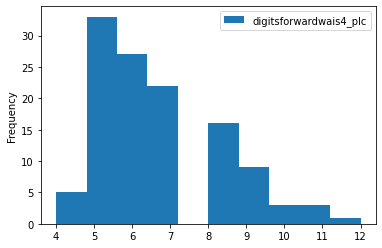

In [73]:
WAIS4DigitSymbolBattery.check_battery(map_neuro)

## Modified Wisconson Card Sort

Currently only a placeholder.

In [75]:
# export 
# hide

class mWCSTBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        test_definition = os.path.join(root_data, 'norms/placeholders/mWCST.yaml')
        calc = TestCalculator.from_config(yaml.full_load(open(test_definition)))
        
        return mWCSTBattery(calc, 
                                ['mwcstcat_plc', 'mwcstpersev_plc', 
                                 'mwcsterrors_plc', 'mwcstpercentpersev_plc'], 
                                z_scaled=False)

Input: 
 mwcstcat:6.0
 mwcsterrors:5.0
 mwcstpersev:2.0
Calculating: ['mwcstcat_plc']
Used Equation: mwcstcat = 6.0 = mwcstcat_plc 

Calculating: ['mwcstpersev_plc']
Used Equation: mwcstpersev = 2.0 = mwcstpersev_plc 

Calculating: ['mwcsterrors_plc']
Used Equation: mwcsterrors = 5.0 = mwcsterrors_plc 

Calculating: ['mwcstpercentpersev']
Used Equation: mwcstpersev/mwcsterrors = 0.4 = mwcstpercentpersev 

Calculating: ['mwcstpercentpersev_plc']
Used Equation: mwcstpercentpersev = 0.4 = mwcstpercentpersev_plc 

Resulting in: 
 mwcstcat_plc:6.0
 mwcsterrors_plc:5.0
 mwcstpercentpersev:0.4
 mwcstpercentpersev_plc:0.4
 mwcstpersev_plc:2.0
None


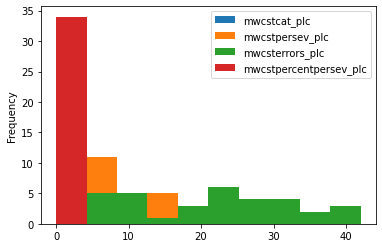

In [76]:
mWCSTBattery.check_battery(map_neuro)

## Stroop

In [77]:
# export 
# hide

class StroopBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        stroop_test_definition = os.path.join(root_data, 'norms/norman/norman_stroop_regnorm.yaml')
        stroop_calc = TestCalculator.from_config(yaml.full_load(open(stroop_test_definition)))
        
        if final_cols is None:
            final_cols = ['stroopword_norman', 'stroopcolor_norman', 'stroopcolorword_norman']
        
        return StroopBattery(stroop_calc, final_cols)

Input: 
 age:62
 education:11
 gender:male
 race:AA
 stroopcolor:53.0
 stroopcolorword:23.0
 stroopword:67.0
Calculating: ['norman_gender']
gender:male -> norman_gender:0 

Calculating: ['norman_race']
race:AA -> norman_race:1 

Calculating: ['stroopcolor_scaled']
stroopcolor matched 49, scaled to 5 

Calculating: ['stroopcolorword_scaled']
stroopcolorword matched 22, scaled to 4 

Calculating: ['stroopword_scaled']
stroopword matched 67, scaled to 4 

Calculating: ['stroopcolor_norman']
Matched (norman_race == 1) & ((age >= 18) & (age <= 66)), applied ((stroopcolor_scaled - (0.3102*(education-13.92)+(-0.1006)*(age-40.67)+1.4915*norman_gender+8.2672))/2.6643)*10+50 = -0.08092857410952234 

Calculating: ['stroopcolorword_norman']
Matched (norman_race == 1) & ((age >= 18) & (age <= 66)), applied ((stroopcolorword_scaled - (0.2363*(education-13.94)+(-0.1219)*(age-40.67)+1.9479*norman_gender+7.449))/2.2658)*10+50 = -0.0680338070438701 

Calculating: ['stroopword_norman']
Matched (norman_ra

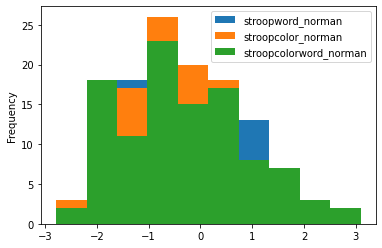

In [78]:
StroopBattery.check_battery(map_neuro)